![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/streamlit_notebooks/ocr/IMAGE_TO_TEXT.ipynb)

# Image to text

To run this yourself, you will need to upload your **Spark OCR** license keys to the notebook. Otherwise, you can look at the example outputs at the bottom of the notebook. To upload license keys, open the file explorer on the left side of the screen and upload `workshop_license_keys.json` to the folder that opens.

For more in-depth tutorials: https://github.com/JohnSnowLabs/spark-ocr-workshop/tree/master/jupyter

## 🔑  1. Colab Setup

Read licence key

In [ ]:
import json, os
from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

Install Dependencies

In [ ]:
# Installing Spark OCR
! pip install spark-ocr==$OCR_VERSION --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.2.1 spark-nlp==$PUBLIC_VERSION

<b><h1><font color='darkred'>!!! ATTENTION !!! </font><h1><b>

<b>After running previous cell, <font color='darkred'>RESTART the COLAB RUNTIME </font> and go ahead.<b>

# 🔑  Importing Libraries

In [ ]:
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [ ]:
import sparkocr
import sys
from pyspark.sql import SparkSession
from sparkocr import start
import base64
from sparkocr.transformers import *
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F
from sparkocr.enums import *
from sparkocr.utils import display_images

#📌 Start Spark Session

In [ ]:
# Start spark
spark = sparkocr.start(secret=SPARK_OCR_SECRET,
                       nlp_version=PUBLIC_VERSION
                       )

spark

Spark version: 3.2.1
Spark NLP version: 4.4.4
Spark OCR version: 4.4.2



In [ ]:
! pip install --upgrade scikit-image==0.19.3

## ⏩ Image to Text

The notebook describes how to detect and extract text from images using Spark OCR's ImageTextDetector and ImageToText transformers. Here is an explanation of the text recognition process outlined:

- Load the Image: The notebook starts by loading an example image into a Spark DataFrame using the binaryFile data source. The image is read from the resources of the Spark OCR Python package.

- Convert Binary Data to Image: Next, the binary image data is converted to the internal Image format using the BinaryToImage transformer. The transformed image DataFrame is then displayed using the display_images() function.

- Text Detection: ImageTextDetector transformer, which is used for detecting text on images. This transformer is based on the "Character Region Awareness for Text Detection" model. Various parameters such as sizeThreshold, textThreshold, linkThreshold, width, and height can be set to customize the text detection process.

- Show Detected Regions: The detected text regions are shown by selecting and displaying the text_regions column from the output DataFrame. This provides information about the position, size, score, label, and angle of the detected text regions.

- Draw Detected Regions: The ImageDrawRegions transformer is used to draw the detected text regions on the original image. This transformer takes the image DataFrame and the text_regions column as inputs and produces an output DataFrame with the drawn regions.

- Text Recognition: To recognize the text within the detected regions, the notebook suggests using the ImageSplitRegions and ImageToText transformers. The ImageSplitRegions transformer splits the original image into sub-images based on the detected text regions. Then, the ImageToText transformer performs text recognition on each sub-image, extracting the text content. The extracted text is added to the output DataFrame as the text column.




## ⌛ 2. Download and read scanned pdf image

In [ ]:
from sparkocr.utils import display_tables

In [ ]:
!wget https://image.slidesharecdn.com/editingscannedpdfdocuments-100816013015-phpapp01/95/editing-scanned-pdf-documents-1-728.jpg -O 1.jpg
!wget https://www.reneelab.com/wp-content/uploads/sites/2/2015/11/target-500x600.png -O 2.jpg

In [ ]:
image_df = spark.read.format("binaryFile").load('./*.jpg').cache()
image_df.show()

+-------------------+--------------------+------+--------------------+
|               path|    modificationTime|length|             content|
+-------------------+--------------------+------+--------------------+
|file:/content/2.jpg| 2016-12-19 13:28:45|145284|[89 50 4E 47 0D 0...|
|file:/content/1.jpg|2023-06-16 07:17:...| 82227|[FF D8 FF E0 00 1...|
+-------------------+--------------------+------+--------------------+



## 3. Construct the OCR pipeline

In [ ]:
# Read binary as image
binary_to_image = BinaryToImage()
binary_to_image.setInputCol('content')
binary_to_image.setOutputCol('image')

# Scale image
scaler = ImageScaler()
scaler.setInputCol('image')
scaler.setOutputCol('scaled_image')
scaler.setScaleFactor(2.0)

# Binarize using adaptive tresholding
binarizer = ImageAdaptiveThresholding()
binarizer.setInputCol('scaled_image')
binarizer.setOutputCol('binarized_image')
binarizer.setBlockSize(91)
binarizer.setOffset(70)

# Remove extraneous objects from image
remove_objects = ImageRemoveObjects()
remove_objects.setInputCol('binarized_image')
remove_objects.setOutputCol('cleared_image')
remove_objects.setMinSizeObject(30)
remove_objects.setMaxSizeObject(4000)

# Apply morphology opening
morpholy_operation = ImageMorphologyOperation()
morpholy_operation.setKernelShape(KernelShape.DISK)
morpholy_operation.setKernelSize(1)
morpholy_operation.setOperation('closing')
morpholy_operation.setInputCol('cleared_image')
morpholy_operation.setOutputCol('corrected_image')

# Extract text from corrected image with OCR
ocr = ImageToText()
ocr.setInputCol('binarized_image')
ocr.setOutputCol('text')
ocr.setConfidenceThreshold(50)
ocr.setIgnoreResolution(False)

# Create pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    scaler,
    binarizer,
    remove_objects,
    morpholy_operation,
    ocr
])

## 4. Run OCR pipeline

In [ ]:
result = pipeline.transform(image_df).cache()

## 5. Visualize Results

Display result dataframe

In [ ]:
result.select("text", "confidence").show()

+--------------------+-----------------+
|                text|       confidence|
+--------------------+-----------------+
|ADVERTISEMENT.\n\...|91.87201182047527|
|Editing Scanned P...|95.61167602539062|
+--------------------+-----------------+



Display text and images

In [ ]:
from sparkocr.utils import display_image


    Image #0:
    Origin: file:/content/2.jpg
    Resolution: 0 dpi
    Width: 500 px
    Height: 600 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


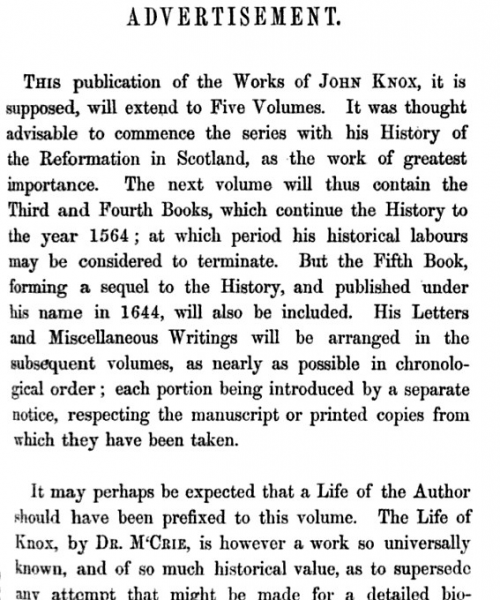

ADVERTISEMENT.

Tuts publication of the Works of Jonn Kwox, it is
supposed, will extend to Five Volumes. It was thought
advisable to commence the series with his History of
the Reformation in Scotland, as the work of greatest
importance. The next volume will thus contain the
Third and Fourth Books, which continue the History to
the year 1564; at which period his historical labours
may be considered to terminate. But the Fifth Book,
forming a sequel to the History, and published under
his name in 1644, will also be included. His Letters
and Miscellancous Writings will be arranged in the
subsequent volumes, as nearly as possible in chronolo-
gical order; each portion being introduced by a separate
nvtice, respecting the manuscript or printed copies from
which they have been taken.

It may perhaps be expected that a Life of the Author
thould have been prefixed to this volume. The Life of
Knox, by Dr. M-Crig, is however a work so universally
known, and of so much historical value, as to su

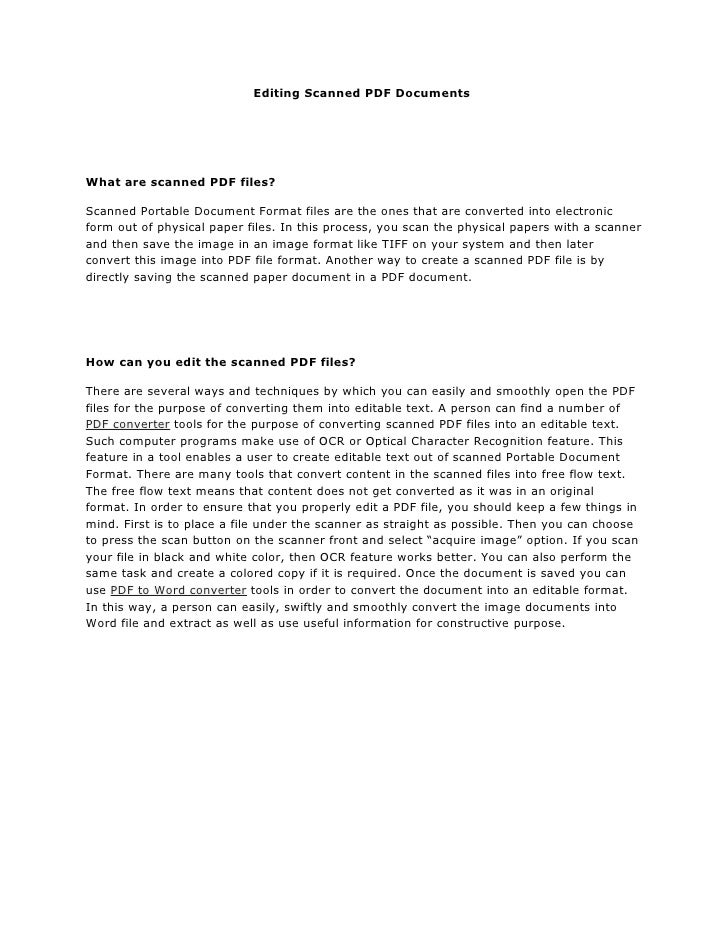

Editing Scanned PDF Documents

What are scanned PDF files?

Scanned Portable Document Format fites are the ones that are converted into electronic
form out of physical paper files. In this process, you scan the physical papers with a scanner
and then save the image in an image format like TIFF on your system and then later
convert this image into PDF file format. Another way to create a scanned PDF file is by
directly saving the scanned paper document in a PDF document.

How can you edit the scanned PDF files?

There are several ways and techniques by which you can easity and smoothly open the PDF
files for the purpose of converting them into editable text. A person can find a number of
PDF converter tools for the purpose of converting scanned PDF files into an editable text.
Such computer programs make use of OCR or Optical Character Recognition feature. This
feature in a tool enables a user to create editable text out of scanned Portable Document
Format. There are many tools that con

In [ ]:
for r in result.distinct().collect():
  display_image(r.image)
  print (r.text)

Saving intermediate processing results as jpg

In [ ]:
from sparkocr.utils import to_pil_image

In [ ]:
for r in result.distinct().collect():

    img = to_pil_image(r.binarized_image, r.binarized_image.mode)
    img.save('img_binarized.jpg')
